In [4]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

## Prepare Data

### Load data

In [8]:
def load_cifar10(BATCH_SIZE=64, NUM_WORKERS=2):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5),
                              (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data',
                                            train=True,
                                            download=True,
                                            transform=transform)

    trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])

    # shuffle the data to make sure model is not seeing data in the same order every epoch
    trainloader = torch.utils.data.DataLoader(trainset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=BATCH_SIZE, shuffle=False)

    testset = torchvision.datasets.CIFAR10(root='./data',
                                           train=False,
                                           download=True,
                                           transform=transform)

    # shuffling on test data is not necessary
    testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=NUM_WORKERS)

    return (trainloader, val_loader, testloader)


train_loader, val_loader, test_loader = load_cifar10(64, 4)

Files already downloaded and verified
Files already downloaded and verified


### Verify data

In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

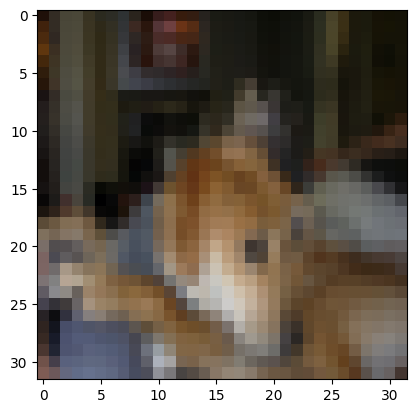

dog


In [23]:
def imshow(img):
    img = img / 2 + 0.5 # convert back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_images(n, imageloader, labels):
    dataiter = iter(imageloader)
    images, labels = next(dataiter)
    for i in range(n):
        imshow(torchvision.utils.make_grid(images[i]))
        print(class_names[labels[i]])


plot_images(1, train_loader, class_names)

## Define the Convolutional Neural Network

## First Model

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 channels, 5x5 kernel, 120 output nodes
        self.fc2 = nn.Linear(120, 84) # 120 input nodes, 84 output nodes
        self.fc3 = nn.Linear(84, 10) # 84 input nodes, 10 output nodes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 1st convolutional layer
        x = self.pool(F.relu(self.conv2(x))) # 2nd convolutional layer
        x = x.view(-1, 16 * 5 * 5) # flatten the tensor
        x = F.relu(self.fc1(x)) # 1st fully connected layer
        x = F.relu(self.fc2(x)) # 2nd fully connected layer
        x = self.fc3(x) # 3rd fully connected layer
        return x


### Define the loss function and optimizer

In [54]:
model1 = CNN()
print(model1)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

### Model training

In [27]:
# Initialize the training and validation logs
training_log1 = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(10):
    model1.train()  # Set the model1 to training mode
    running_loss = 0.0
    total_batches = len(train_loader)
    
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{10}', total=total_batches)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / total_batches
    training_log1['epoch'].append(epoch)
    training_log1['train_loss'].append(avg_train_loss)

    # Validation phase
    model1.eval()  # Set the model1 to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Operations inside don't track history
        for data in val_loader:
            inputs, labels = data
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    training_log1['val_loss'].append(avg_val_loss)
    training_log1['val_accuracy'].append(val_accuracy)

    # Print training and validation results
    print(f"Epoch {epoch+1}/{10}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/10: 100%|██████████| 704/704 [00:37<00:00, 18.86it/s]


Epoch 1/10, Train Loss: 2.2984, Val Loss: 2.2885, Val Accuracy: 11.42%


Epoch 2/10: 100%|██████████| 704/704 [00:36<00:00, 19.52it/s]


Epoch 2/10, Train Loss: 2.2019, Val Loss: 2.0441, Val Accuracy: 26.64%


Epoch 3/10: 100%|██████████| 704/704 [00:37<00:00, 18.76it/s]


Epoch 3/10, Train Loss: 1.9192, Val Loss: 1.8017, Val Accuracy: 33.70%


Epoch 4/10: 100%|██████████| 704/704 [00:37<00:00, 19.01it/s]


Epoch 4/10, Train Loss: 1.7192, Val Loss: 1.6568, Val Accuracy: 39.58%


Epoch 5/10: 100%|██████████| 704/704 [00:39<00:00, 18.04it/s]


Epoch 5/10, Train Loss: 1.6197, Val Loss: 1.5884, Val Accuracy: 41.16%


Epoch 6/10: 100%|██████████| 704/704 [00:38<00:00, 18.35it/s]


Epoch 6/10, Train Loss: 1.5560, Val Loss: 1.5273, Val Accuracy: 44.20%


Epoch 7/10: 100%|██████████| 704/704 [00:36<00:00, 19.13it/s]


Epoch 7/10, Train Loss: 1.4948, Val Loss: 1.4701, Val Accuracy: 46.84%


Epoch 8/10: 100%|██████████| 704/704 [00:36<00:00, 19.49it/s]


Epoch 8/10, Train Loss: 1.4406, Val Loss: 1.4205, Val Accuracy: 49.06%


Epoch 9/10: 100%|██████████| 704/704 [00:36<00:00, 19.46it/s]


Epoch 9/10, Train Loss: 1.3900, Val Loss: 1.3816, Val Accuracy: 50.82%


Epoch 10/10: 100%|██████████| 704/704 [00:36<00:00, 19.50it/s]


Epoch 10/10, Train Loss: 1.3471, Val Loss: 1.3250, Val Accuracy: 52.76%


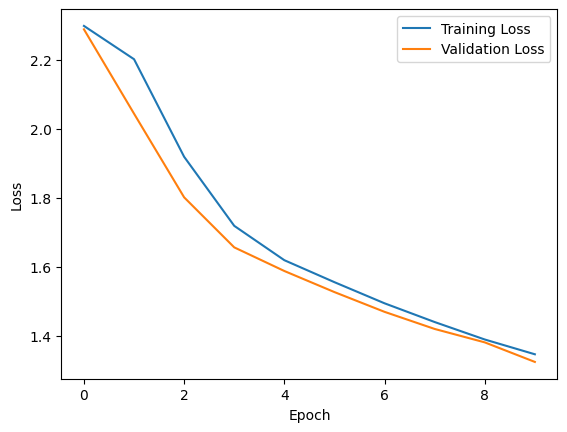

In [29]:
plt.plot(training_log1['epoch'], training_log1['train_loss'], label='Training Loss')
plt.plot(training_log1['epoch'], training_log1['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model testing

In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]}%')

Accuracy of the network on the 10000 test images: 51.93%
Accuracy of airplane: 66.07142857142857%
Accuracy of automobile: 62.0%
Accuracy of bird: 27.848101265822784%
Accuracy of cat: 24.65753424657534%
Accuracy of deer: 25.454545454545453%
Accuracy of dog: 55.932203389830505%
Accuracy of frog: 58.92857142857143%
Accuracy of horse: 64.0625%
Accuracy of ship: 62.06896551724138%
Accuracy of truck: 58.97435897435897%


## Second Model(Improved Model)

In [47]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # smaller kernel, more filters
        self.bn1 = nn.BatchNorm2d(16)  # batch normalization
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # additional convolution layer
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 120)
        self.dropout = nn.Dropout(0.3)  # dropout layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # apply BN before ReLU
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # additional layer with BN and pooling
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 128 * 2 * 2)  # flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # apply dropout before the next FC layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [48]:
model = ImprovedCNN()
print(model)

ImprovedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Define the loss function and optimizer

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Model training

In [50]:
# Initialize the training and validation logs
training_log = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(10):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_batches = len(train_loader)
    
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{10}', total=total_batches)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / total_batches
    training_log['epoch'].append(epoch)
    training_log['train_loss'].append(avg_train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Operations inside don't track history
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    training_log['val_loss'].append(avg_val_loss)
    training_log['val_accuracy'].append(val_accuracy)

    # Print training and validation results
    print(f"Epoch {epoch+1}/{10}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/10: 100%|██████████| 704/704 [01:00<00:00, 11.62it/s]


Epoch 1/10, Train Loss: 1.9128, Val Loss: 1.5536, Val Accuracy: 41.88%


Epoch 2/10: 100%|██████████| 704/704 [00:59<00:00, 11.86it/s]


Epoch 2/10, Train Loss: 1.5199, Val Loss: 1.3620, Val Accuracy: 49.60%


Epoch 3/10: 100%|██████████| 704/704 [01:00<00:00, 11.66it/s]


Epoch 3/10, Train Loss: 1.3198, Val Loss: 1.2383, Val Accuracy: 55.76%


Epoch 4/10: 100%|██████████| 704/704 [01:00<00:00, 11.61it/s]


Epoch 4/10, Train Loss: 1.1757, Val Loss: 1.1074, Val Accuracy: 60.08%


Epoch 5/10: 100%|██████████| 704/704 [01:00<00:00, 11.73it/s]


Epoch 5/10, Train Loss: 1.0854, Val Loss: 0.9875, Val Accuracy: 64.02%


Epoch 6/10: 100%|██████████| 704/704 [02:03<00:00,  5.68it/s]


Epoch 6/10, Train Loss: 1.0090, Val Loss: 1.0040, Val Accuracy: 64.80%


Epoch 7/10: 100%|██████████| 704/704 [01:18<00:00,  8.99it/s]


Epoch 7/10, Train Loss: 0.9474, Val Loss: 0.9508, Val Accuracy: 66.08%


Epoch 8/10: 100%|██████████| 704/704 [01:14<00:00,  9.51it/s]


Epoch 8/10, Train Loss: 0.8958, Val Loss: 0.8622, Val Accuracy: 69.60%


Epoch 9/10: 100%|██████████| 704/704 [01:12<00:00,  9.76it/s]


Epoch 9/10, Train Loss: 0.8432, Val Loss: 0.9332, Val Accuracy: 67.70%


Epoch 10/10: 100%|██████████| 704/704 [01:13<00:00,  9.64it/s]


Epoch 10/10, Train Loss: 0.8032, Val Loss: 0.8265, Val Accuracy: 70.70%


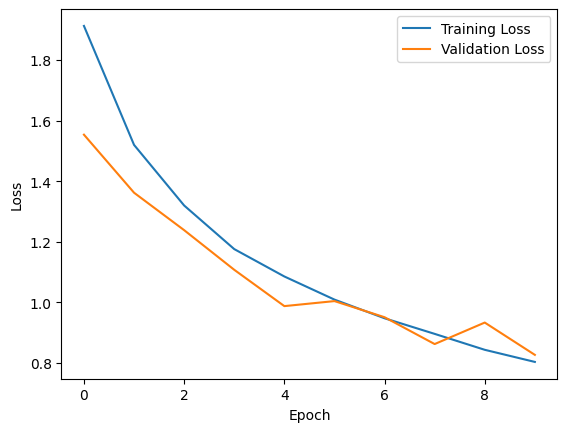

In [51]:
plt.plot(training_log['epoch'], training_log['train_loss'], label='Training Loss')
plt.plot(training_log['epoch'], training_log['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

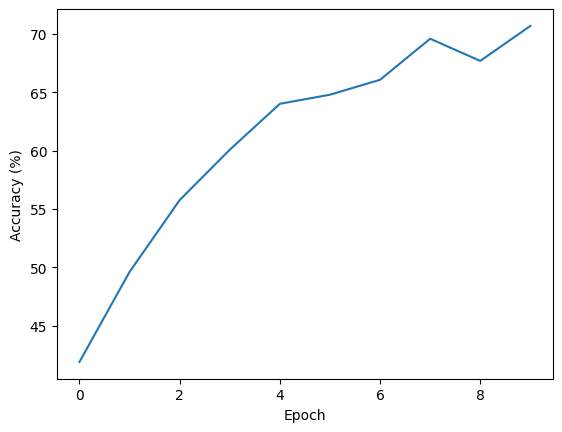

In [52]:
plt.plot(training_log['epoch'], training_log['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

### Model testing

In [53]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]}%')


Accuracy of the network on the 10000 test images: 70.53%
Accuracy of airplane: 80.35714285714286%
Accuracy of automobile: 82.0%
Accuracy of bird: 62.0253164556962%
Accuracy of cat: 35.61643835616438%
Accuracy of deer: 61.81818181818182%
Accuracy of dog: 57.6271186440678%
Accuracy of frog: 76.78571428571429%
Accuracy of horse: 78.125%
Accuracy of ship: 82.75862068965517%
Accuracy of truck: 75.64102564102564%
